In [1]:
import random
import matplotlib.pyplot as plt
import networkx as nx

**The Plan**
- Define a super simple MDP. Start without any cycles, literally just make it a directed acyclic graph.
- Assign random numbers to all state-action pairs in this MDP (e.g. sampled from a gaussian with mean 0, variance 1), i.e. a maximally dense reward function.
- Write a function which computes the set of optimal policies assuming that those numbers are interpreted as a reward function.
- Generate many (e.g. 1000) random reward functions, and check that the optimal policies they lead to are non-uniform, i.e. some policies are more likely than others to be generated via this process.

Hypotheses: (speculative)
- Some policies will be more likely than others to be generated (what structure in particular?)

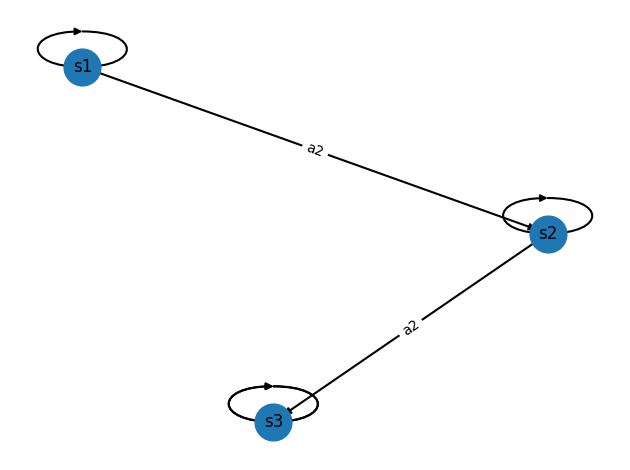

MDP Summary:
States: s1, s2, s3
Actions: a1, a2
Discount Factor: 0.9
Optimal Policy: {'s1': 'a2', 's2': 'a2', 's3': 'a1'}


In [2]:
### Defining a markov decision process
### Thanks ChatGPT (again) for supplying the framework and maybe ~50% of the raw code

import numpy as np

class MDP:
    def __init__(self, states, actions, transition_function, reward_function, gamma):
        self.states = states
        self.actions = actions
        self.transition_function = transition_function  # Function: (s, a, s') -> Probability
        self.reward_function = reward_function  # Function: (s, a, s') -> Reward, now passed during initialization
        self.gamma = gamma

    def get_possible_actions(self, state):
        return self.actions

    def transition(self, state, action):
        """
        Given a state and action, return a list of (probability, next_state, reward) triples.
        """
        return [(self.transition_function(state, action, next_state),
                 next_state,
                 self.reward_function(state, action, next_state))
                for next_state in self.states]

    def compute_optimal_policy_value(self, values):
        # Initialize the policy for each state to None
        policy = {state: None for state in self.states}

        # After the value function has converged, determine the optimal policy
        for state in self.states:
            # Calculate the expected value of each action using the converged value function
            action_values = {
                action: sum(p * (reward + self.gamma * values[next_state])
                            for p, next_state, reward in self.transition(state, action))
                for action in self.get_possible_actions(state)
            }

            # Select the action that has the highest expected value
            # print(action_values)
            max_value = float("-inf")
            max_action = None
            for action, value in action_values.items():
                if value > max_value or abs(value - max_value) < 1e-9 and random.choice([True, False]):
                    max_value = value
                    max_action = action
            policy[state] = max_action

        # Return the optimal policy and the converged value function
        return policy
    
    def compute_optimal_policy_q_value(self, q_values):
        # Initialize the policy for each state to None
        policy = {state: None for state in self.states}

        # After the value function has converged, determine the optimal policy
        for state in self.states:
            # Calculate the expected value of each action using the converged value function
            action_values = {
                action: q_values[state, action]
                for action in self.get_possible_actions(state)
            }

            # Select the action that has the highest expected value
            max_value = float("-inf")
            max_action = None
            for action, value in action_values.items():
                if value > max_value or abs(value - max_value) < 1e-9 and random.choice([True, False]):
                    max_value = value
                    max_action = action
            policy[state] = max_action

        # Return the optimal policy and the converged value function
        return policy
    
    def compute_optimal_policy(self, epsilon=0.01, max_iterations=1000):
        """
        Compute the optimal policy using value iteration.
        
        Args:
            epsilon (float): Convergence threshold
            max_iterations (int): Maximum number of iterations
        
        Returns:
            dict: The optimal policy
        """
        # Initialize the value function for each state to zero
        values = {state: 0 for state in self.states}

        # Repeat until convergence or maximum iterations reached
        for _ in range(max_iterations):
            # Keep track of the maximum change in the value function across all states
            delta = 0

            # Update the value function for each state
            for state in self.states:
                # Store the current value function for the state
                v = values[state]

                # Calculate the value for all possible actions from the current state
                action_values = [
                    sum(p * (reward + self.gamma * values[next_state])
                        for p, next_state, reward in self.transition(state, action))
                    for action in self.get_possible_actions(state)
                ]

                # Update the value function to the maximum value across all actions
                values[state] = max(action_values)

                # Update delta to the maximum change in the value function
                delta = max(delta, abs(v - values[state]))

            # If the maximum change in the value function is less than epsilon, we've converged
            if delta < epsilon:
                # print(f"Converged after {_} iterations")
                break
        return self.compute_optimal_policy_value(values)

    def plot_graph(self):
        G = nx.MultiDiGraph()

        # Add nodes for each state
        for state in self.states:
            G.add_node(state)

        # Add edges for each action and transition
        for state in self.states:
            for action in self.actions:
                for next_state in self.states:
                    if self.transition_function(state, action, next_state) > 0:
                        reward = self.reward_function(state, action, next_state)
                        G.add_edge(state, next_state, action=action, weight=reward)

        # plt.figure(figsize=(12, 8))  # Increase the plot size
        pos = nx.spring_layout(G, k=0.5, iterations=20)  # k: Optimal distance between nodes. Increase/decrease to spread nodes out

        nx.draw_networkx_nodes(G, pos, node_size=700)
        nx.draw_networkx_labels(G, pos)

        # Draw edges and add labels
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1.5)

        edge_labels = {(u, v): f"{d['action']}" for u, v, d in G.edges(data=True)}
        
        # Calculate edge label positions at the midpoint of the edges
        edge_label_pos = {edge: ((pos[edge[0]][0] + pos[edge[1]][0]) / 2, (pos[edge[0]][1] + pos[edge[1]][1]) / 2) 
                        for edge in G.edges()}

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

        plt.axis('off')
        plt.tight_layout()  # Adjust layout to prevent cutting off edge labels
        plt.show()

    def __str__(self):
        states_str = ', '.join(self.states)
        actions_str = ', '.join(self.actions)
        return (f"MDP Summary:\n"
                f"States: {states_str}\n"
                f"Actions: {actions_str}\n"
                f"Discount Factor: {self.gamma}")


# Example MDP setup
states = ['s1', 's2', 's3']
actions = ['a1', 'a2']
def transition_function(s, a, s_prime): #simple function for demonstration
    if a == actions[0]:
        return 1 if s_prime == s else 0
    else: # s1 to s2, s2 to s3
        return 1 if (s == 's1' and s_prime == 's2') or (s == 's2' and s_prime == 's3') or (s == 's3' and s_prime == 's3') else 0

# Define a reward function that assigns random rewards for each state-action pair
def random_reward_function(states, actions, transition_function = transition_function):
    """Initializes a reward function that assigns random rewards to state-action pairs."""
    rewards = {}
    for state in states:
        for action in actions:
            for next_state in states:
                rewards[(state, action, next_state)] = np.random.normal(0, 1) if transition_function(state, action, next_state) > 0 else 0
                # Gaussian distribution, mean=0, variance=1
    # print(rewards)
    return lambda s, a, s_prime: rewards[(s, a, s_prime)]

gamma = 0.9 # Discount factor
# Create an MDP object with the randomized reward function

mdp = MDP(states, actions, transition_function, random_reward_function(states, actions), gamma)
optimal_policy = mdp.compute_optimal_policy()
mdp.plot_graph()
print(mdp)
print("Optimal Policy:", optimal_policy)

In [3]:
### Oops, there's already a function for this in the mdptoolbox library
import mdptoolbox, mdptoolbox.example
import numpy as np

# Generate a simple example MDP problem
P, R = mdptoolbox.example.forest(S=3, r1=4, r2=2, p=0.1)

# P is the transition probability matrix
# P[action][state, nextState] = probability of transitioning from state to nextState given action
# R is the reward matrix
# R[state, action] = reward received when taking action in state

# Initialize the Value Iteration algorithm
vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)

# Run the Value Iteration algorithm
vi.run()

# Output results
print("Policy:", vi.policy)  # Best action in each state
print("Value:", vi.V)  # Value of each state


Policy: (0, 0, 0)
Value: (5.051970000000001, 8.291970000000001, 12.291970000000001)


In [4]:
### Test 1000 reward functions, see what policies we get

NUM_REWARD_FUNCTIONS = 1000
states = ['s1', 's2', 's3']
actions = ['a1', 'a2']
gamma = 0.9

def collate_results(optimal_policies, print_result = True):
    opt_pol_counts = {}
    for policy in optimal_policies:
        key = str(policy)
        if key in opt_pol_counts:
            opt_pol_counts[key] += 1
        else:
            opt_pol_counts[key] = 1
    
    if print_result:
        print("Optimal Policy Counts:")
        sorted_keys = sorted(opt_pol_counts.keys())
        for key in sorted_keys:
            print(key, ":", opt_pol_counts[key])

    # print(sum(opt_pol_counts.values()))
    return opt_pol_counts

def test_randomness(states, actions, gamma, print_result = True, transition_function = transition_function):
    random_reward_functions = [random_reward_function(states, actions, transition_function) for _ in range(NUM_REWARD_FUNCTIONS)]

    mdps = [MDP(states, actions, transition_function, reward_function, gamma) for reward_function in random_reward_functions]
    optimal_policies = [mdp.compute_optimal_policy() for mdp in mdps]
    # optimal_policies = [mdp.compute_optimal_policy() for mdp in ([mdps[0]] * 1000)] 
    # ^ debug to make sure compute_optimal_policy is deterministic
    # print("Optimal Policies:", optimal_policies)

    return collate_results(optimal_policies, print_result)

pol_counts = {}
for _ in range(10):
    entry = test_randomness(states, actions, gamma)
    for k in entry.keys():
        if k in pol_counts:
            pol_counts[k] += entry[k]
        else:
            pol_counts[k] = entry[k]
pol_counts

Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 45
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 46
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 86
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 101
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 111
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 129
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 247
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 235
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 53
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 50
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 100
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 77
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 123
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 125
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 233
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 239
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 53
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 47
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 90
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 101
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 124
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} 

{"{'s1': 'a2', 's2': 'a2', 's3': 'a1'}": 2373,
 "{'s1': 'a2', 's2': 'a1', 's3': 'a1'}": 1286,
 "{'s1': 'a2', 's2': 'a2', 's3': 'a2'}": 2317,
 "{'s1': 'a1', 's2': 'a2', 's3': 'a1'}": 916,
 "{'s1': 'a1', 's2': 'a1', 's3': 'a1'}": 450,
 "{'s1': 'a1', 's2': 'a2', 's3': 'a2'}": 947,
 "{'s1': 'a2', 's2': 'a1', 's3': 'a2'}": 1279,
 "{'s1': 'a1', 's2': 'a1', 's3': 'a2'}": 432}

- Sanity check: since a1 and a2 do exactly the same thing at s3 (100% chance of going back to s3), the number of times two policies that differ only by s3's action are optimal should be roughly equal. This is indeed what we find
- At least based off the simple transition function we wrote earlier, there are clear differences in which policies are preferred (not uniform). Not sure about exactly why

In [5]:
### Chi-squared test for optimal policy counts (null hypothesis: all policies are equally likely)
from scipy.stats import chisquare

NUM_REWARD_FUNCTIONS = 10**3
NUM_VALUE_FUNCTIONS = 10**3
def chi_squared_test(opt_pol_counts, reward_or_value = True):
    """
    Conducts a chi-squared test on the optimal policy counts.
    Warning: This test is not valid for small sample sizes.
    """
    expected = [(NUM_REWARD_FUNCTIONS if reward_or_value else NUM_VALUE_FUNCTIONS) / len(opt_pol_counts)] * len(opt_pol_counts)
    chi2, p = chisquare(list(opt_pol_counts.values()), f_exp=expected)
    print(f"Chi-squared: {chi2}, p-value: {p}")

for _ in range(3):
    chi_squared_test(test_randomness(states, actions, gamma))

Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 46
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 33
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 89
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 90
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 134
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 126
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 235
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 247
Chi-squared: 354.336, p-value: 1.453580149215935e-72
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 40
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 56
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 78
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 102
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 103
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 131
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 239
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 251
Chi-squared: 352.928, p-value: 2.909939142342403e-72
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 51
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 54
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 97
{'s1': 'a1', 's2':

In [6]:
### Sparse reward function test

def sparse_reward_function(states, actions, sparsity = 0.9, transition_function = transition_function):
    rewards = {}
    for state in states:
        for action in actions:
            for next_state in states:
                if random.random() < sparsity or transition_function(state, action, next_state) == 0:
                    rewards[(state, action, next_state)] = 0
                else:
                    rewards[(state, action, next_state)] = np.random.normal(0, 1)
    return lambda s, a, s_prime: rewards[(s, a, s_prime)]

def test_sparsity(states, actions, gamma, sparsity = 0.9, print_result = True, transition_function = transition_function):
    random_reward_functions = [sparse_reward_function(states, actions, sparsity, transition_function) for _ in range(NUM_REWARD_FUNCTIONS)]

    mdps = [MDP(states, actions, transition_function, reward_function, gamma) for reward_function in random_reward_functions]
    optimal_policies = [mdp.compute_optimal_policy() for mdp in mdps]
    # print(len(optimal_policies))

    return collate_results(optimal_policies, print_result)


for i in [0.1, 0.5, 0.9, 0.99, 0.999, 0.9999]:
    test_sparsity(states, actions, gamma, i)

Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 42
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 40
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 93
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 84
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 144
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 129
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 228
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 240
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 65
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 57
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 81
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 85
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 115
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 128
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 232
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 237
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 107
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 103
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 95
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 103
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 131
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} 

- The distribution of policies evens out to uniform as sparsity increases

In [7]:
### Directly inserting a value function

def test_value_function(states, actions, gamma, print_result = True, transition_function = transition_function):
    # values = [{state: random.random() for state in states} for _ in range(NUM_VALUE_FUNCTIONS)]
    # mdp = [MDP(states, actions, transition_function, random_reward_function(states, actions, transition_function), gamma) for _ in range(NUM_VALUE_FUNCTIONS)]
    # opt_policies = [mdp[i].compute_optimal_policy_value(values[i]) for i in range(NUM_VALUE_FUNCTIONS)]
    # return collate_results(opt_policies, print_result)

    # I realized that you can't really do this, because the value function is dependent on the reward function
    # So if we randomize the reward function, we're not really measuring "randomness" very well
    # Instead we can randomize a q-function, and then use that to compute the value function
    # As a sanity check, this should result in uniform optimal policy counts

    q_functions = [{(state, action): random.random() for state in states for action in actions} for _ in range(NUM_VALUE_FUNCTIONS)]
    mdp = [MDP(states, actions, transition_function, random_reward_function(states, actions, transition_function), gamma) for _ in range(NUM_VALUE_FUNCTIONS)]
    opt_policies = [mdp[i].compute_optimal_policy_q_value(q_functions[i]) for i in range(NUM_VALUE_FUNCTIONS)]
    return collate_results(opt_policies, print_result)

for _ in range(3):
    chi_squared_test(test_value_function(states, actions, gamma))
    

Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 131
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 124
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 120
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 131
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 116
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 139
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 124
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 115
Chi-squared: 3.8080000000000007, p-value: 0.8016074949529435
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 131
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 124
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 137
{'s1': 'a1', 's2': 'a2', 's3': 'a2'} : 120
{'s1': 'a2', 's2': 'a1', 's3': 'a1'} : 115
{'s1': 'a2', 's2': 'a1', 's3': 'a2'} : 116
{'s1': 'a2', 's2': 'a2', 's3': 'a1'} : 119
{'s1': 'a2', 's2': 'a2', 's3': 'a2'} : 138
Chi-squared: 4.736, p-value: 0.6921437868082726
Optimal Policy Counts:
{'s1': 'a1', 's2': 'a1', 's3': 'a1'} : 121
{'s1': 'a1', 's2': 'a1', 's3': 'a2'} : 143
{'s1': 'a1', 's2': 'a2', 's3': 'a1'} : 135
{'s1'

**Hypotheses**:
1. Maybe reward-generated optimal policies loop more often
2. Maybe they try not to get stuck (preserve optionality/power-seeking)
3. Maybe they go for more options

In [8]:
### A more complicated MDP

NUM_REWARD_FUNCTIONS = 10**3
states = ['s1', 's2', 's3', 's4', 's5', 's6', 's7']
actions = ['a1', 'a2', 'a3']
gamma = 0.9
def transition_function(s, a, s_prime):
    if a == actions[0]:
        return 1 if s == s_prime else 0
    elif a == actions[1]:
        return 1 if (s == 's1' and s_prime == 's2') or (s == 's2' and s_prime == 's4') or (s == 's3' and s_prime == 's5') or (s == 's5' and s_prime == 's6') or (s == 's6' and s_prime == 's7') else 0
    else:
        return 1 if (s == 's1' and s_prime == 's3') or (s == 's2' and s_prime == 's3')  or (s == 's3' and s_prime == 's2') else 0

def concise_printing(opt_pol_counts):
    print("Optimal Policy Counts:")
    sorted_keys = sorted(opt_pol_counts.keys())
    out = ""
    for key in sorted_keys:
        out += (str(opt_pol_counts[key]) + ", ")
    print(out)

def print_top_k(opt_pol_counts, k=5):
    sorted_keys = sorted(opt_pol_counts.keys(), key = lambda x: -opt_pol_counts[x])
    for key in sorted_keys[:k]:
        print(key, ":", opt_pol_counts[key])

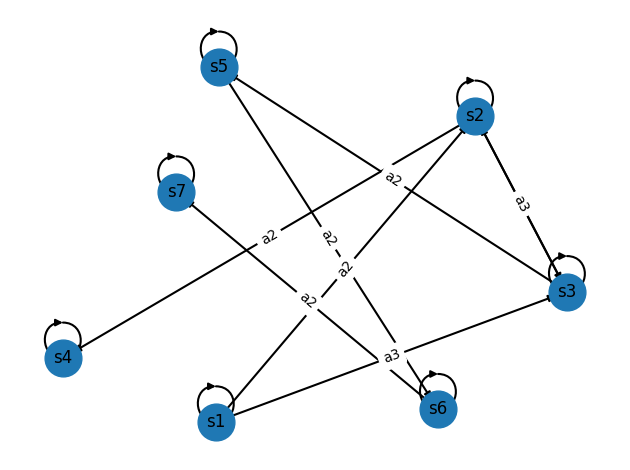

Optimal Policy Counts:
1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 8, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 6, 1, 1, 1, 4, 2, 2, 7, 2, 2, 1, 1, 1, 2, 2, 4, 4, 1, 2, 1, 3, 2, 2, 1, 1, 1, 8, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 2, 1, 15, 1, 2, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 3, 3, 3, 6, 4, 1, 1, 1, 3, 2, 2, 2, 5, 6, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 5, 1, 3, 2, 7, 2, 2, 1, 2, 11, 14, 9, 20, 3, 2, 4, 1, 2, 1, 4, 2, 2, 1, 2, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 3, 3, 1, 2, 3, 4, 4, 2, 10, 3, 2, 1, 1, 1, 2, 3, 3, 1, 7, 1, 1, 1, 2, 2, 1, 8, 1, 2, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 2, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 2, 1, 2, 1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, 4, 1, 2, 2, 3, 2, 4, 3, 1, 1, 1, 1, 2, 2, 1, 1, 11, 4, 8, 10, 1, 1, 5, 1, 2, 1, 3, 1, 1, 1, 3, 2, 4, 6, 1

In [9]:
MDP(states, actions, transition_function, random_reward_function(states, actions), gamma).plot_graph()
opt_pol_counts = test_randomness(states, actions, gamma, False, transition_function)
concise_printing(opt_pol_counts)
print(len(opt_pol_counts)) # 3^7 = 2187, but not all policies are enumerated
chi_squared_test(opt_pol_counts)
print_top_k(opt_pol_counts, 10)

- Definitely seems like optimal policies gravitate towards loops; some kind of "explore-exploit" dynamic going on
- s1 and s2 tend to gravitate towards a3, meaning that optionality/power-seeking is favored, although this conclusion is less strong in my opinion
- Clearly the distribution of optimal policies is *very* non-uniform, even with a more complicated MDP

In [10]:
NUM_REWARD_FUNCTIONS = 10**3
for i in [0.0, 0.1, 0.5, 0.7, 0.8, 0.9, 0.99]:
    opt_pol_counts = test_sparsity(states, actions, gamma, i, False, transition_function)
    chi_squared_test(opt_pol_counts)
    print_top_k(opt_pol_counts)

Chi-squared: 1462.0999999999997, p-value: 1.8726137951249573e-111
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a2', 's6': 'a2', 's7': 'a1'} : 33
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a3', 's5': 'a2', 's6': 'a2', 's7': 'a1'} : 21
{'s1': 'a2', 's2': 'a2', 's3': 'a3', 's4': 'a1', 's5': 'a2', 's6': 'a2', 's7': 'a1'} : 15
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a2', 's6': 'a1', 's7': 'a1'} : 14
{'s1': 'a2', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a2', 's6': 'a2', 's7': 'a1'} : 14
Chi-squared: 1476.9799999999998, p-value: 1.2693561713738776e-118
{'s1': 'a2', 's2': 'a2', 's3': 'a3', 's4': 'a1', 's5': 'a2', 's6': 'a2', 's7': 'a1'} : 26
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a2', 's6': 'a2', 's7': 'a1'} : 23
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a3', 's5': 'a2', 's6': 'a2', 's7': 'a1'} : 21
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a2', 's5': 'a2', 's6': 'a2', 's7': 'a1'} : 18
{'s1': 'a2', 's2': 'a1', 's3': 'a3', 's4': 'a1', 's5': 'a2

- Sparsity is still a little weird to me: it doesn't seem like it has a dramatic effect until *all* (s, a, s') rewards go to 0, in which case the optimal policy becomes random. This tells me that maybe the force affecting the non-uniformness of optimal policies has more to do with the structure of the MDP than sparsity.

In [11]:
NUM_VALUE_FUNCTIONS = 10**4
opt_pol_counts = test_value_function(states, actions, gamma, False, transition_function)
chi_squared_test(opt_pol_counts, False)
print_top_k(opt_pol_counts, k = 10)

Chi-squared: 2039.0503999999996, p-value: 0.9655758830389306
{'s1': 'a3', 's2': 'a2', 's3': 'a1', 's4': 'a1', 's5': 'a3', 's6': 'a3', 's7': 'a3'} : 12
{'s1': 'a2', 's2': 'a2', 's3': 'a2', 's4': 'a3', 's5': 'a1', 's6': 'a3', 's7': 'a2'} : 12
{'s1': 'a1', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a3', 's6': 'a3', 's7': 'a3'} : 12
{'s1': 'a3', 's2': 'a1', 's3': 'a3', 's4': 'a1', 's5': 'a2', 's6': 'a1', 's7': 'a2'} : 12
{'s1': 'a2', 's2': 'a2', 's3': 'a3', 's4': 'a1', 's5': 'a3', 's6': 'a1', 's7': 'a3'} : 11
{'s1': 'a2', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a2', 's6': 'a1', 's7': 'a2'} : 11
{'s1': 'a1', 's2': 'a2', 's3': 'a3', 's4': 'a3', 's5': 'a1', 's6': 'a1', 's7': 'a1'} : 11
{'s1': 'a3', 's2': 'a1', 's3': 'a2', 's4': 'a2', 's5': 'a1', 's6': 'a2', 's7': 'a1'} : 11
{'s1': 'a2', 's2': 'a1', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a3', 's7': 'a3'} : 11
{'s1': 'a1', 's2': 'a3', 's3': 'a3', 's4': 'a1', 's5': 'a1', 's6': 'a2', 's7': 'a3'} : 11


Two ideas to test:
1. Are random policies "power-seeking" (in the Turner definition, i.e. pursue optionality)? If true, this would undermine existing results
    - At first glance, if POWER is roughly the number of outward arrows from a node and random policies tend towards nodes with lots of inward arrows, then they aren’t necessarily connected
    - Unless the MDP is double-sided, i.e. if P_a(s, s’) ~ 1 for some (s, a, s’), then there exists action a’ such that P_a’(s’, s) ~ 1
2. What other hypotheses are there about policies in MDPs? (e.g. length of loop = "goal complexity", distance to loop = "agency") The end goal here would be some non-trivial demonstration of X hypothesis

**Let's just try generating a bunch of MDPs and finding patterns:**

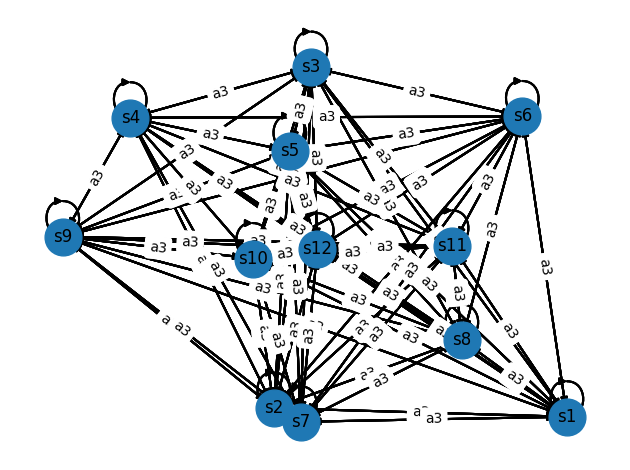

Randomness Test:
{'s1': 'a3', 's2': 'a1', 's3': 'a1', 's4': 'a3', 's5': 'a3', 's6': 'a1', 's7': 'a3', 's8': 'a2', 's9': 'a3', 's10': 'a1', 's11': 'a1', 's12': 'a1'} : 1
{'s1': 'a1', 's2': 'a1', 's3': 'a1', 's4': 'a3', 's5': 'a2', 's6': 'a1', 's7': 'a3', 's8': 'a3', 's9': 'a1', 's10': 'a1', 's11': 'a1', 's12': 'a3'} : 1
{'s1': 'a1', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a2', 's8': 'a1', 's9': 'a1', 's10': 'a1', 's11': 'a3', 's12': 'a1'} : 1
{'s1': 'a1', 's2': 'a2', 's3': 'a3', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a3', 's8': 'a3', 's9': 'a2', 's10': 'a1', 's11': 'a2', 's12': 'a2'} : 1
{'s1': 'a1', 's2': 'a1', 's3': 'a3', 's4': 'a1', 's5': 'a2', 's6': 'a2', 's7': 'a3', 's8': 'a1', 's9': 'a2', 's10': 'a2', 's11': 'a3', 's12': 'a3'} : 1
Chi-squared: 0.0, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a3', 's2': 'a2', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a1', 's7': 'a3', 's8': 'a3', 's9': 'a1', 's10': 'a1', 's11': 'a2', 's12': 'a2'} : 1
{'s1': 'a2

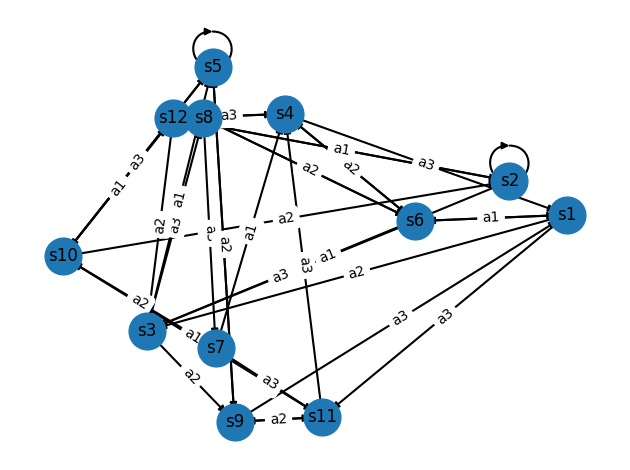

Randomness Test:
{'s1': 'a3', 's2': 'a3', 's3': 'a1', 's4': 'a2', 's5': 'a2', 's6': 'a2', 's7': 'a2', 's8': 'a3', 's9': 'a1', 's10': 'a2', 's11': 'a1', 's12': 'a1'} : 3
{'s1': 'a2', 's2': 'a1', 's3': 'a1', 's4': 'a3', 's5': 'a1', 's6': 'a3', 's7': 'a2', 's8': 'a3', 's9': 'a2', 's10': 'a3', 's11': 'a1', 's12': 'a2'} : 3
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a2', 's5': 'a2', 's6': 'a2', 's7': 'a2', 's8': 'a3', 's9': 'a1', 's10': 'a2', 's11': 'a1', 's12': 'a1'} : 3
{'s1': 'a2', 's2': 'a3', 's3': 'a1', 's4': 'a2', 's5': 'a2', 's6': 'a1', 's7': 'a2', 's8': 'a3', 's9': 'a2', 's10': 'a1', 's11': 'a1', 's12': 'a1'} : 2
{'s1': 'a2', 's2': 'a1', 's3': 'a1', 's4': 'a1', 's5': 'a1', 's6': 'a3', 's7': 'a1', 's8': 'a3', 's9': 'a2', 's10': 'a3', 's11': 'a2', 's12': 'a1'} : 2
Chi-squared: 26.900000000000006, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a3', 's2': 'a3', 's3': 'a1', 's4': 'a2', 's5': 'a2', 's6': 'a2', 's7': 'a2', 's8': 'a3', 's9': 'a1', 's10': 'a2', 's11': 'a1', 's12': 'a1'}

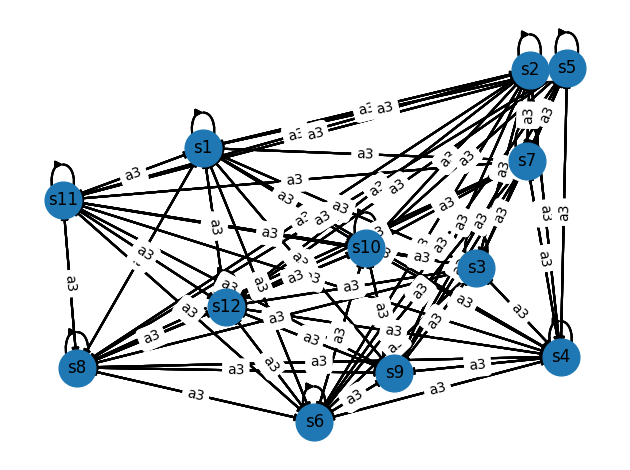

Randomness Test:
{'s1': 'a3', 's2': 'a3', 's3': 'a1', 's4': 'a3', 's5': 'a3', 's6': 'a3', 's7': 'a2', 's8': 'a2', 's9': 'a2', 's10': 'a1', 's11': 'a3', 's12': 'a2'} : 2
{'s1': 'a3', 's2': 'a2', 's3': 'a3', 's4': 'a1', 's5': 'a3', 's6': 'a3', 's7': 'a1', 's8': 'a1', 's9': 'a1', 's10': 'a3', 's11': 'a2', 's12': 'a3'} : 1
{'s1': 'a2', 's2': 'a2', 's3': 'a3', 's4': 'a2', 's5': 'a1', 's6': 'a1', 's7': 'a2', 's8': 'a1', 's9': 'a1', 's10': 'a2', 's11': 'a2', 's12': 'a3'} : 1
{'s1': 'a1', 's2': 'a3', 's3': 'a3', 's4': 'a1', 's5': 'a1', 's6': 'a3', 's7': 'a1', 's8': 'a3', 's9': 'a1', 's10': 'a2', 's11': 'a1', 's12': 'a2'} : 1
{'s1': 'a3', 's2': 'a2', 's3': 'a3', 's4': 'a2', 's5': 'a1', 's6': 'a1', 's7': 'a2', 's8': 'a1', 's9': 'a2', 's10': 'a2', 's11': 'a3', 's12': 'a2'} : 1
Chi-squared: 0.9979999999999998, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a1', 's2': 'a3', 's3': 'a3', 's4': 'a1', 's5': 'a1', 's6': 'a3', 's7': 'a2', 's8': 'a3', 's9': 'a2', 's10': 'a3', 's11': 'a2', 's12': 'a1'}

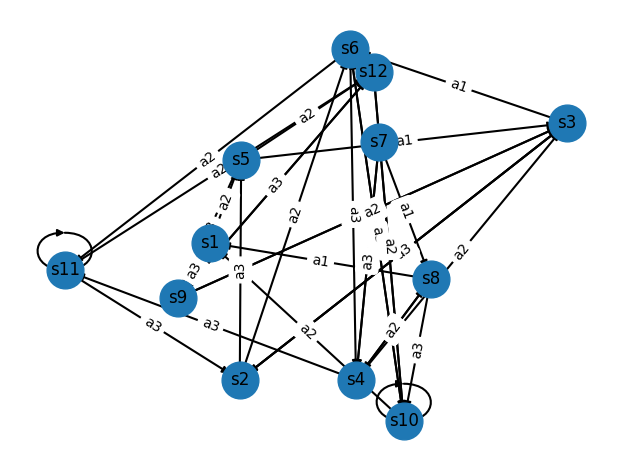

Randomness Test:
{'s1': 'a2', 's2': 'a1', 's3': 'a1', 's4': 'a2', 's5': 'a2', 's6': 'a3', 's7': 'a3', 's8': 'a2', 's9': 'a2', 's10': 'a3', 's11': 'a2', 's12': 'a3'} : 2
{'s1': 'a2', 's2': 'a2', 's3': 'a2', 's4': 'a3', 's5': 'a3', 's6': 'a2', 's7': 'a2', 's8': 'a2', 's9': 'a3', 's10': 'a3', 's11': 'a1', 's12': 'a2'} : 2
{'s1': 'a2', 's2': 'a3', 's3': 'a1', 's4': 'a3', 's5': 'a2', 's6': 'a1', 's7': 'a1', 's8': 'a3', 's9': 'a3', 's10': 'a1', 's11': 'a2', 's12': 'a2'} : 2
{'s1': 'a2', 's2': 'a1', 's3': 'a3', 's4': 'a2', 's5': 'a1', 's6': 'a2', 's7': 'a2', 's8': 'a1', 's9': 'a1', 's10': 'a2', 's11': 'a3', 's12': 'a3'} : 2
{'s1': 'a1', 's2': 'a2', 's3': 'a1', 's4': 'a3', 's5': 'a1', 's6': 'a2', 's7': 'a3', 's8': 'a2', 's9': 'a2', 's10': 'a3', 's11': 'a1', 's12': 'a1'} : 2
Chi-squared: 8.837999999999997, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a1', 's2': 'a2', 's3': 'a1', 's4': 'a1', 's5': 'a2', 's6': 'a1', 's7': 'a1', 's8': 'a1', 's9': 'a3', 's10': 'a2', 's11': 'a2', 's12': 'a1'} 

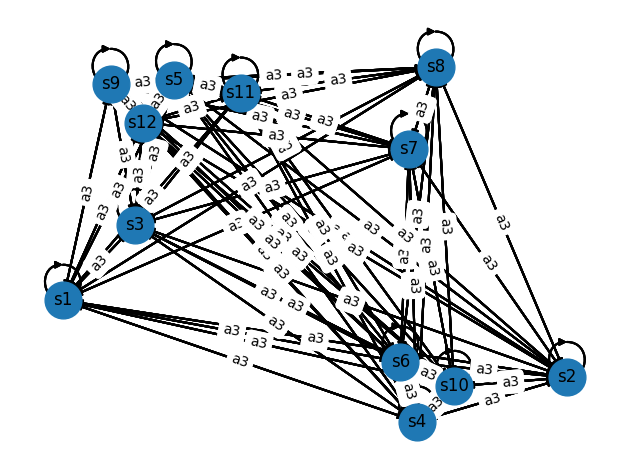

Randomness Test:
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a3', 's5': 'a1', 's6': 'a2', 's7': 'a1', 's8': 'a2', 's9': 'a3', 's10': 'a3', 's11': 'a1', 's12': 'a1'} : 2
{'s1': 'a3', 's2': 'a1', 's3': 'a3', 's4': 'a1', 's5': 'a3', 's6': 'a1', 's7': 'a1', 's8': 'a2', 's9': 'a3', 's10': 'a3', 's11': 'a3', 's12': 'a3'} : 2
{'s1': 'a3', 's2': 'a1', 's3': 'a3', 's4': 'a1', 's5': 'a1', 's6': 'a2', 's7': 'a2', 's8': 'a2', 's9': 'a3', 's10': 'a2', 's11': 'a3', 's12': 'a3'} : 1
{'s1': 'a2', 's2': 'a1', 's3': 'a3', 's4': 'a2', 's5': 'a2', 's6': 'a3', 's7': 'a2', 's8': 'a3', 's9': 'a3', 's10': 'a3', 's11': 'a3', 's12': 'a2'} : 1
{'s1': 'a2', 's2': 'a1', 's3': 'a2', 's4': 'a1', 's5': 'a3', 's6': 'a2', 's7': 'a2', 's8': 'a3', 's9': 'a1', 's10': 'a2', 's11': 'a2', 's12': 'a3'} : 1
Chi-squared: 1.9920000000000004, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a2', 's2': 'a3', 's3': 'a2', 's4': 'a3', 's5': 'a2', 's6': 'a3', 's7': 'a3', 's8': 'a1', 's9': 'a1', 's10': 'a2', 's11': 'a1', 's12': 'a2'}

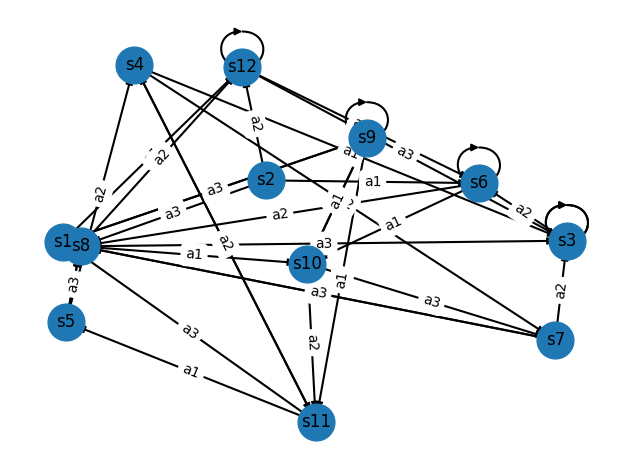

Randomness Test:
{'s1': 'a1', 's2': 'a2', 's3': 'a2', 's4': 'a3', 's5': 'a3', 's6': 'a2', 's7': 'a1', 's8': 'a2', 's9': 'a1', 's10': 'a2', 's11': 'a3', 's12': 'a2'} : 5
{'s1': 'a1', 's2': 'a2', 's3': 'a2', 's4': 'a2', 's5': 'a1', 's6': 'a2', 's7': 'a1', 's8': 'a2', 's9': 'a2', 's10': 'a3', 's11': 'a3', 's12': 'a2'} : 4
{'s1': 'a1', 's2': 'a2', 's3': 'a2', 's4': 'a3', 's5': 'a1', 's6': 'a2', 's7': 'a3', 's8': 'a2', 's9': 'a1', 's10': 'a2', 's11': 'a3', 's12': 'a2'} : 4
{'s1': 'a2', 's2': 'a3', 's3': 'a2', 's4': 'a3', 's5': 'a2', 's6': 'a1', 's7': 'a3', 's8': 'a1', 's9': 'a3', 's10': 'a1', 's11': 'a3', 's12': 'a1'} : 4
{'s1': 'a2', 's2': 'a1', 's3': 'a2', 's4': 'a3', 's5': 'a2', 's6': 'a1', 's7': 'a1', 's8': 'a1', 's9': 'a3', 's10': 'a1', 's11': 'a3', 's12': 'a1'} : 3
Chi-squared: 67.52, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a1', 's2': 'a2', 's3': 'a2', 's4': 'a3', 's5': 'a3', 's6': 'a2', 's7': 'a1', 's8': 'a2', 's9': 'a1', 's10': 'a2', 's11': 'a3', 's12': 'a2'} : 9
{'s1': '

In [12]:
NUM_MDPs = 6
states = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12']
actions = ['a1', 'a2', 'a3']
def chi_squared_sparsity(opt_pol_counts, opt_pol_counts_sparse):
    """
    Chi-squared test for sparsity test
    (It seems like the categories are too small for the chi-squared test to be meaningful, 
    but I'm not sure how to fix that)
    """
    # assert len(opt_pol_counts) == len(opt_pol_counts_sparse)
    observed = list(opt_pol_counts.values())
    expected = list(opt_pol_counts_sparse.values())
    chi2, p = chisquare(observed, f_exp=expected)
    print(f"Chi-squared: {chi2}, p-value: {p}")
    
def random_transition_function(distributed = True):
    transitions = {}
    for state in states:
        for action in actions:
            if distributed:
                probs = np.random.dirichlet(np.ones(len(states)))
            else:
                probs = np.zeros(len(states))
                probs[random.randint(0, len(states) - 1)] = 1
            # print(probs)
            for i, next_state in enumerate(states):
                transitions[(state, action, next_state)] = probs[i]
    return lambda s, a, s_prime: transitions[(s, a, s_prime)]

def thorough_mdp_test(states, actions, i, transition_generator = random_transition_function, plot_graph = True):
    # Generate random transition function and reward function
    
    # Create MDP object
    transition_function = transition_generator(i % 2 == 0)
    reward_function = lambda s, a, s_prime: np.random.normal(0, 1) if transition_function(s, a, s_prime) > 0 else 0
    mdp = MDP(states, actions, transition_function, reward_function, gamma)
    if plot_graph:
        mdp.plot_graph()
    
    # Run tests (reward randomized each time)
    print("Randomness Test:")
    results1 = test_randomness(states, actions, gamma, False, transition_function)
    print_top_k(results1, 5)
    chi_squared_test(results1)
    
    print("Sparsity Test: (sparsity 0.9)")
    results2 = test_sparsity(states, actions, gamma, 0.9, False, transition_function)
    print_top_k(results2, 5)
    chi_squared_test(results2)
    
    print("Value Function Test:")
    results3 = test_value_function(states, actions, gamma, False, transition_function)
    print_top_k(results3, 5)
    chi_squared_test(results3, False)
    
    print("-------------------------")

for i in range(NUM_MDPs):
    thorough_mdp_test(states, actions, i)


- After running the above block of code a few times, it seems like when you run the experiments on a denser graph (where the transition function can possibly send the policy to any other state), the non-uniformity results break down. Perhaps our hypotheses (e.g. that loops or out-arrows matter) depend on a "sparse" MDP
- In some sense this kind of dense MDP is maximally optional (there is chance you can get to any state from any other state, depending on the transition function), meaning that the amount of POWER between nodes is relatively even. Hence "power-seeking" is not necessarily very useful here
- When running the above block on larger MDPs (e.g. twelve nodes instead of seven), you can see that sparser reward functions *do* make a difference in the optimal policies distribution (see the chi-squared score), but only with the sparser MDPs, and it's relatively small compared to the other patterns we've noticed

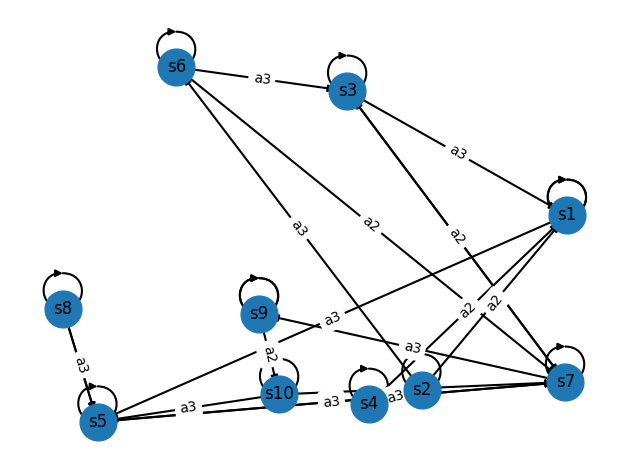

Randomness Test:
{'s1': 'a3', 's2': 'a3', 's3': 'a1', 's4': 'a3', 's5': 'a2', 's6': 'a3', 's7': 'a2', 's8': 'a2', 's9': 'a2', 's10': 'a2'} : 9
{'s1': 'a3', 's2': 'a3', 's3': 'a1', 's4': 'a3', 's5': 'a3', 's6': 'a3', 's7': 'a2', 's8': 'a2', 's9': 'a2', 's10': 'a2'} : 9
{'s1': 'a3', 's2': 'a2', 's3': 'a3', 's4': 'a2', 's5': 'a1', 's6': 'a3', 's7': 'a2', 's8': 'a2', 's9': 'a2', 's10': 'a3'} : 8
{'s1': 'a2', 's2': 'a2', 's3': 'a3', 's4': 'a2', 's5': 'a3', 's6': 'a3', 's7': 'a2', 's8': 'a3', 's9': 'a2', 's10': 'a2'} : 6
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a2', 's5': 'a3', 's6': 'a2', 's7': 'a1', 's8': 'a3', 's9': 'a2', 's10': 'a2'} : 6
Chi-squared: 441.188, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a3', 's5': 'a3', 's6': 'a2', 's7': 'a3', 's8': 'a3', 's9': 'a2', 's10': 'a2'} : 13
{'s1': 'a3', 's2': 'a3', 's3': 'a1', 's4': 'a3', 's5': 'a2', 's6': 'a3', 's7': 'a2', 's8': 'a2', 's9': 'a2', 's10': 'a2'} : 13
{'s1': 'a3', 's2': 'a3', 's3': 'a2

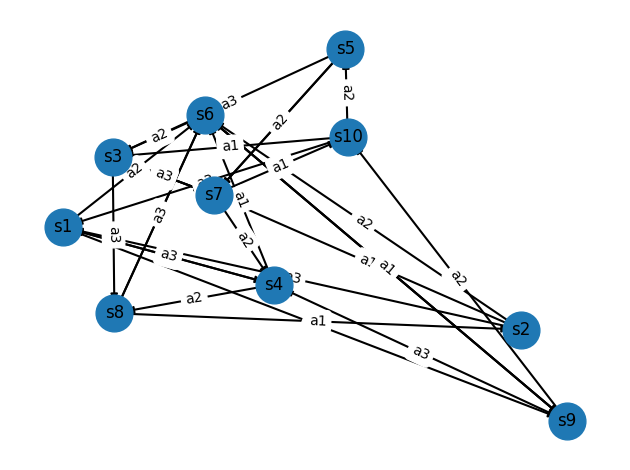

Randomness Test:
{'s1': 'a2', 's2': 'a2', 's3': 'a3', 's4': 'a2', 's5': 'a3', 's6': 'a3', 's7': 'a1', 's8': 'a3', 's9': 'a3', 's10': 'a2'} : 2
{'s1': 'a2', 's2': 'a2', 's3': 'a2', 's4': 'a1', 's5': 'a3', 's6': 'a2', 's7': 'a2', 's8': 'a1', 's9': 'a1', 's10': 'a1'} : 2
{'s1': 'a2', 's2': 'a1', 's3': 'a1', 's4': 'a3', 's5': 'a2', 's6': 'a2', 's7': 'a1', 's8': 'a2', 's9': 'a2', 's10': 'a2'} : 2
{'s1': 'a1', 's2': 'a3', 's3': 'a2', 's4': 'a2', 's5': 'a2', 's6': 'a1', 's7': 'a2', 's8': 'a3', 's9': 'a2', 's10': 'a3'} : 2
{'s1': 'a3', 's2': 'a3', 's3': 'a1', 's4': 'a3', 's5': 'a2', 's6': 'a2', 's7': 'a2', 's8': 'a1', 's9': 'a3', 's10': 'a3'} : 2
Chi-squared: 22.848000000000003, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a3', 's2': 'a1', 's3': 'a3', 's4': 'a2', 's5': 'a3', 's6': 'a2', 's7': 'a2', 's8': 'a1', 's9': 'a3', 's10': 'a1'} : 10
{'s1': 'a3', 's2': 'a1', 's3': 'a3', 's4': 'a2', 's5': 'a3', 's6': 'a2', 's7': 'a3', 's8': 'a1', 's9': 'a3', 's10': 'a1'} : 9
{'s1': 'a3', 's2': 'a2',

In [13]:
NUM_STATES = 10
states = ['s' + str(i) for i in range(1, NUM_STATES + 1)]
actions = ['a1', 'a2', 'a3']
NUM_MDPs = 1
def transition_function_sparse_loops(j):
    """
    Sparse transition function with guaranteed loops
    """
    transitions = {}
    for state in states:
        for action in actions:
            if action == actions[0]:
                for next_state in states:
                    transitions[(state, action, next_state)] = 1 if next_state == state else 0
            else: # sparse randomness
                probs = np.zeros(len(states))
                probs[random.randint(0, len(states) - 1)] = 1
                # print(probs)
                for i, next_state in enumerate(states):
                    transitions[(state, action, next_state)] = probs[i]
    return lambda s, a, s_prime: transitions[(s, a, s_prime)]

def transition_function_sparse_no_loops(j):
    """
    Sparse transition function with no loops
    Each (s, a) pair randomly transitions to one other state that is not itself with probability 1
    """
    transitions = {}
    for state in states:
        for action in actions:
            probs = np.zeros(len(states) - 1)
            probs[random.randint(0, len(states) - 2)] = 1
            # print(probs)
            next_state_passed = False
            for i in range(len(states)):
                next_state = states[i]
                if next_state == state:
                    next_state_passed = True
                    transitions[(state, action, next_state)] = 0
                    continue
                transitions[(state, action, next_state)] = probs[i - 1 if next_state_passed else i]
                
    return lambda s, a, s_prime: transitions[(s, a, s_prime)]
    
for i in range(NUM_MDPs):
    thorough_mdp_test(states, actions, i, transition_function_sparse_loops, plot_graph = True)
    thorough_mdp_test(states, actions, i, transition_function_sparse_no_loops, plot_graph = True)
    # Number of transitions: 100 * 3 * 100 = 30,000
    # Computations to get optimal policy: two for loops, calculate value for all possible actions
    # --> (# iterations, usually ~50) * 100 * (3 * 100) = 150,000

It seems like self-loops makes a difference in distribution, yet a1 (which guarantees a self-loop) doesn't seem to show up in the most common optimal policies in the self-loop graph. Maybe most of the policies are "pointing towards" another loop?

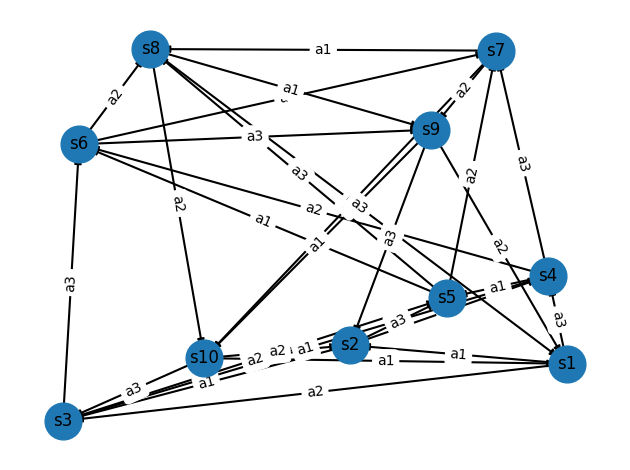

Randomness Test:
{'s1': 'a2', 's2': 'a1', 's3': 'a3', 's4': 'a2', 's5': 'a1', 's6': 'a1', 's7': 'a2', 's8': 'a1', 's9': 'a2', 's10': 'a3'} : 2
{'s1': 'a2', 's2': 'a1', 's3': 'a1', 's4': 'a2', 's5': 'a2', 's6': 'a2', 's7': 'a3', 's8': 'a2', 's9': 'a1', 's10': 'a3'} : 2
{'s1': 'a2', 's2': 'a3', 's3': 'a1', 's4': 'a3', 's5': 'a3', 's6': 'a1', 's7': 'a1', 's8': 'a2', 's9': 'a1', 's10': 'a3'} : 2
{'s1': 'a2', 's2': 'a2', 's3': 'a2', 's4': 'a3', 's5': 'a2', 's6': 'a2', 's7': 'a3', 's8': 'a2', 's9': 'a1', 's10': 'a1'} : 2
{'s1': 'a2', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a3', 's6': 'a1', 's7': 'a1', 's8': 'a2', 's9': 'a1', 's10': 'a3'} : 2
Chi-squared: 10.758000000000001, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a1', 's2': 'a3', 's3': 'a3', 's4': 'a3', 's5': 'a3', 's6': 'a2', 's7': 'a3', 's8': 'a3', 's9': 'a2', 's10': 'a1'} : 4
{'s1': 'a2', 's2': 'a3', 's3': 'a3', 's4': 'a2', 's5': 'a1', 's6': 'a1', 's7': 'a3', 's8': 'a2', 's9': 'a1', 's10': 'a3'} : 4
{'s1': 'a3', 's2': 'a3', 

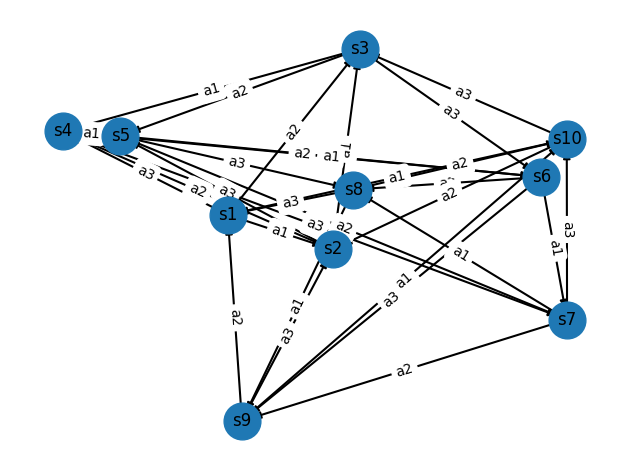

Randomness Test:
{'s1': 'a1', 's2': 'a1', 's3': 'a2', 's4': 'a3', 's5': 'a3', 's6': 'a2', 's7': 'a1', 's8': 'a3', 's9': 'a1', 's10': 'a1'} : 2
{'s1': 'a3', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a2', 's6': 'a2', 's7': 'a2', 's8': 'a2', 's9': 'a1', 's10': 'a3'} : 2
{'s1': 'a3', 's2': 'a1', 's3': 'a3', 's4': 'a1', 's5': 'a1', 's6': 'a2', 's7': 'a2', 's8': 'a3', 's9': 'a2', 's10': 'a2'} : 2
{'s1': 'a2', 's2': 'a1', 's3': 'a2', 's4': 'a1', 's5': 'a3', 's6': 'a2', 's7': 'a1', 's8': 'a2', 's9': 'a1', 's10': 'a1'} : 2
{'s1': 'a2', 's2': 'a2', 's3': 'a1', 's4': 'a1', 's5': 'a2', 's6': 'a2', 's7': 'a2', 's8': 'a3', 's9': 'a3', 's10': 'a3'} : 2
Chi-squared: 4.950000000000001, p-value: 1.0
Sparsity Test: (sparsity 0.9)
{'s1': 'a2', 's2': 'a3', 's3': 'a2', 's4': 'a1', 's5': 'a3', 's6': 'a3', 's7': 'a2', 's8': 'a1', 's9': 'a3', 's10': 'a2'} : 4
{'s1': 'a3', 's2': 'a2', 's3': 'a1', 's4': 'a3', 's5': 'a3', 's6': 'a3', 's7': 'a3', 's8': 'a2', 's9': 'a1', 's10': 'a3'} : 3
{'s1': 'a2', 's2': 'a3', '

In [14]:
NUM_MDPs = 2
def transition_function_sparse_one_loop(j):
    """
    Sparse transition function with one guaranteed loop
    """
    transitions = {}
    for i in range(len(states)):
        for k in range(1, len(actions) + 1): # loop with "sides" of length k
            for l in range(len(states)):
                transitions[(states[i], actions[k - 1], states[l])] = 1 if (i + k) % len(states) == l else 0
    return lambda s, a, s_prime: transitions[(s, a, s_prime)]

for i in range(NUM_MDPs):
    thorough_mdp_test(states, actions, i, transition_function_sparse_one_loop, plot_graph = True)

When you don't have short loops, both reward and sparse reward effects disappear.